#### Imports

In [1]:
import os

import sys
sys.path.append('../scripts')

import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.patches import Circle
import seaborn as sns
from scipy.stats import gaussian_kde
from mpl_toolkits.mplot3d import Axes3D

#Neural Networks
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dense, Dropout
from sklearn.calibration import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras import models, layers
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

#Personal functions
from build_cnn_database import get_all_clusters, count_max_intensity, build_database_metric, get_cnn_db_folder,clean_cnn_db_folder


2023-11-27 13:48:15.768225: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-27 13:48:15.769693: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-27 13:48:15.790821: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-27 13:48:15.790853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-27 13:48:15.791598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

#### Useful Variables

In [2]:
current_directory = os.getcwd()
current_directory = os.getcwd()
clusters_folder_path = os.path.join(current_directory,'../ressources/clusters')
clusters_filename = 'clusters_dataset.csv'
cluster_file_path = os.path.join(clusters_folder_path,clusters_filename)

#### Load Dataset

In [3]:
#We load the data from the generated clusters file (clusters_nb)
clusters_df = pd.read_csv(cluster_file_path)

#We round the magnitudes 1 one decimal as it's precise enough for our work
clusters_df['mag'] = round(clusters_df['mag'],1)

#### Feature Engineering

    We applied unsupervised learning to determien our different clusters of earthquakes. 
    We have been able to obtain relatively convincing results. Now, considering our results as sufficient, we can use them to deploy neural networks algorithms. ALL THE RESULTS FROM THE NEURAL NETWORKS DIRECTLY DEPEND FROM OUR CLUSTERING ALGORITHM.

    We need to chose what we want to predict thanks to our neural networks. One simple idea would be to use some features from the aftershocks to predict the magnitude of the mainshock.

    However, a CNN needs to use data like images to be applied (1D convolution also exists btw...). Then, we can use the information from our clusters to generate a kind of 'signature' for each cluster.

    A common data we have for each aftershock is its distance to the mainshock in kilometers, as well as the distance in time (days). 
    We know that our magnitudes in our new dataset are going from 3.5 (threshold) to at least 9.1 (max magnitude registered at the 20/11/2023). Then, we can create 2D images (2D-histograms), with as many columns as we have bins between 3.5 and mag_max (9.1), with a step of 0.1.
    For example, between 3.5 and 9.1, we have 56 bins of step 0.1 (3.5 - 3.6, 3.6 - 3.7 ... 9.0 - 9.1).
    Notice that we can increase the number of columns by adding a coefficient but it will not be relevant as our data is rounded to 1 decimal.
    
    Regarding the number of rows of our images, it depends of the 'score' we chose to use and the 2D-histogram dimensions. We can globally decide to use twice the number of columns, so it divides the image in 2*n_cols^2 pixels

    The score relies on simple features like delta_days and delta_dist or on features created through features engineering.

In [4]:
#A simple score we can create is the product of delta_days and delta_dist (we add a small value 1 to avoid values between 0 and 1 for aftershocks)
clusters_df['delta_score'] = (1+clusters_df['delta_days'])*(1+clusters_df['delta_dist'])
clusters_df.head(5)

,MC_lab,SC_lab,ST_lab,grid_cell,id,time,latitude,longitude,depth,mag,nearest_area,delta_days,delta_dist,delta_depth,delta_mag,delta_score
0,0,0,4,"(255, 638)",usp00070dk,1995-07-09T20:31:31.470Z,21.984,99.159,10.1,5.9,China,-2.052180,4.313232,2.4,0.9,-5.590474
1,0,0,4,"(255, 637)",usp00070dm,1995-07-09T20:33:32.540Z,21.725,99.086,10.0,5.0,Myanmar,-2.050778,29.136117,2.5,1.8,-31.666377
2,0,0,4,"(255, 637)",usp00070dq,1995-07-09T21:29:14.730Z,21.885,99.116,10.0,4.9,China,-2.012095,12.229204,2.5,1.9,-13.389218
3,0,0,4,"(255, 637)",usp00070ey,1995-07-10T22:43:16.070Z,21.984,99.119,10.0,4.7,China,-0.960691,8.197466,2.5,2.1,0.361542
4,0,0,4,"(261, 627)",usp00070g1,1995-07-11T19:28:41.510Z,24.215,94.527,163.2,4.3,India,-0.095813,539.630854,-150.7,2.5,488.831222


Chose the score (metric) you want to use for the database. Create it if doesnt exists yet :

In [5]:
metric = 'delta_score' #delta_dist #delta_days #delta_score

If you want to work on aftershocks only:

In [6]:
as_only = True #we recommand setting it to True, as basically we should not know when a shock is a foreshock or not...

#### Proposition :
- on regarde à un instant t (par exemple 7j) la distribution des séismes comme on fait pour le moment
- mais on tente de prédire quand aura lieu le dernier séisme par rapport à l'instant t.

--> Par exemple:
- si le dernier aftershock a lieu juste 1 jour après, alors on doit prédire 1 
- si c'est 14 jours après le mainshock, on doit prédire 7 (instant t = 7, 14-7 = 7)
- si y'a pas d'autres shocks, on doit prédire 0

Qqchose de simple: commencer par prédire si y'aura un autre aftershock ou non après X jours

---

#### Creating Database for CNN

In [7]:
dataframe, grouped_dataframe = get_all_clusters(clusters_df, as_only = as_only)
min_mag_as = dataframe.mag.min()

we will work on 195398 quakes spread over 19075 clusters


    Another important step is to determine the parameters of the histogram we will create. We know that all clusters are not spread over the same time distribution, and the number of shocks tends to decrease over time. Therefore, we can limit our data to a time distance, for example 7 days after the mainshock, to capture the "immediate" behavior of shocks.

    This value of n_days can be tuned to get other results. It's important to interpret the resutls in regard of this value!!!

Chose the temporal limit you want to use for the database. Use "float('inf')" if you dont want to apply a time limit :

In [8]:
n_days = 30.25
n_days_df = dataframe.copy()[dataframe['delta_days']<=n_days]

In [9]:
# we iterate a first time over all our clusters to determine the maximum count of a value to then normalize
max_counts,max_mag_as = count_max_intensity(dataframe,grouped_dataframe,n_days,metric,as_only = as_only) #as_only = True if you dont want the mainshock in the sequence, harder for the CNN to find ! 

n_bins = int(10*(max_mag_as-min_mag_as))
mag_bin_range = np.linspace(min_mag_as,max_mag_as, n_bins)
score_bin_range = np.linspace(0,n_days_df[metric].max(), int(len(mag_bin_range)*2.5))

tot_pixels = len(mag_bin_range)*len(score_bin_range)
f"our images are of dimension ({len(mag_bin_range)} x {len(score_bin_range)}) pixels, meaning a total number of {tot_pixels} pixels."

'our images are of dimension (46 x 115) pixels, meaning a total number of 5290 pixels.'

In [10]:
folder_path = get_cnn_db_folder(current_directory, metric)
clean_cnn_db_folder(folder_path)    #force cleaning in case you changed one parameter

All files inside /home/skwyz/Workspace/Heriot/DataMining/group-coursework-rbkt/notebooks/../ressources/cnn/delta_score have been removed.


    We can build our database at this point. However, let's be careful of what we want to predict!! The current code only works to try to predict the magnitude from the aftershock sequence 'signature'. If now we want to predict something else, for example the location of the mainshock in regard of the aftershock sequence, we need to change the structure.

In [11]:
#the images are saved in a folder if you want to use them from another program
build_database_metric(folder_path, grouped_dataframe, n_days, metric, max_counts, mag_bin_range, score_bin_range, as_only = as_only) #should be the same as for count_max_intensity

Database for metric : delta_score created. Contains 7785 files.


#### Load the newly created database

In [12]:
all_files = os.listdir(folder_path)

In [13]:
all_intensities = []
all_aftershocks = []
all_magnitudes = []

for file_name in all_files:
    file_path = os.path.join(folder_path, file_name)
    data = np.load(file_path)
    all_intensities.append(data['counts'])
    all_aftershocks.append(int(file_name.split('__',2)[1]))
    all_magnitudes.append(float(file_name.split('__')[2].split('.npz')[0]))

transformed_aftershocks = [0 if value == 0 else 1 for value in all_aftershocks]

# #We need our input and output data to be of the same type. Our CNN will use the array of all_intensities as input data
all_intensities = np.array(all_intensities)
#Our CNN will use the array of all_magnitudes as labels for our data
all_magnitudes = np.array(all_magnitudes)

all_aftershocks = np.array(all_aftershocks)

all_transformed = np.array(transformed_aftershocks)

In [14]:
num_zeros = (all_transformed == 0).sum()
num_ones = (all_transformed == 1).sum()
num_zeros,num_ones

(6835, 950)

#### Build and Train the CNN :

    All the parameters, including filter kernel size (e.g. (3, 3)), activation functions per layer (e.g. 'relu'), droupout (e.g. 0.25) can be tuned at each layer to try to optimize the results.



In [15]:
outcome_to_predict = 'aftershocks_bool' #'magnitudes'
if outcome_to_predict == 'aftershocks':
    labels = all_aftershocks
elif outcome_to_predict == 'magnitudes':
    labels = all_magnitudes
elif outcome_to_predict == 'aftershocks_bool':
    labels = all_transformed

In [16]:
intensities = all_intensities.reshape(all_intensities.shape + (1,)) #don't touch.

# Step 1: Init the CNN
model = Sequential()


# Step 2: Add layers to the CNN
model.add(Conv2D(64, (5, 5), activation='gelu', input_shape=(mag_bin_range.shape[0]-1, score_bin_range.shape[0]-1, 1))) #dont touch the input shape, 1 for the grayscale
model.add(AveragePooling2D((2, 2))) # Pooling to 2x2. One pooling by convolution !! (double check information)


# Additional Convolutional layers (optional !!!)
model.add(Conv2D(32, (3, 3), activation='tanh'))
model.add(AveragePooling2D((2, 2)))


# Step 3: CNN to Dense layer
model.add(Flatten()) # Flatten layer to transition from convolutional to dense layers


# Step 4: Dense layers (can be more than one !!)
model.add(Dense(64, activation='gelu'))
model.add(Dropout(0.25))  # Dropout for regularization

# model.add(Dense(32, activation='tanh'))
# model.add(Dropout(0.5))  # Dropout for regularization

# Output layer for regression
if 'bool' not in outcome_to_predict:
    model.add(Dense(1, activation='linear'))
    
    # Step 5: Compile Model for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
else:
    model.add(Dense(1, activation='sigmoid'))

    # Step 5: Compile Model for binary classification
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])



# Step 6: Split & Train Model
X_train, X_val, y_train, y_val = train_test_split(all_intensities, labels, test_size=0.2)  #test size : keep it small (0.2 max)
history = model.fit(X_train, y_train, batch_size = 2**4, epochs= 10, validation_data=(X_val, y_val))  #keep it the same, except for epochs (not too big to avoid overfitting)

Epoch 1/10
390/390 [==============================] - 9s 21ms/step - loss: 0.3376 - accuracy: 0.8870 - val_loss: 0.2738 - val_accuracy: 0.9075
Epoch 2/10
390/390 [==============================] - 8s 21ms/step - loss: 0.1963 - accuracy: 0.9249 - val_loss: 0.2062 - val_accuracy: 0.9171
Epoch 3/10
390/390 [==============================] - 10s 25ms/step - loss: 0.1799 - accuracy: 0.9327 - val_loss: 0.2283 - val_accuracy: 0.9133
Epoch 4/10
390/390 [==============================] - 9s 22ms/step - loss: 0.1818 - accuracy: 0.9366 - val_loss: 0.1974 - val_accuracy: 0.9184
Epoch 5/10
390/390 [==============================] - 8s 21ms/step - loss: 0.1692 - accuracy: 0.9374 - val_loss: 0.1851 - val_accuracy: 0.9268
Epoch 6/10
390/390 [==============================] - 8s 21ms/step - loss: 0.1645 - accuracy: 0.9385 - val_loss: 0.1788 - val_accuracy: 0.9268
Epoch 7/10
390/390 [==============================] - 8s 21ms/step - loss: 0.1614 - accuracy: 0.9416 - val_loss: 0.1777 - val_accuracy: 0.931

In [17]:
# Step 7: Evaluate Model
model.evaluate(X_val, y_val)

# Step 8: Make Predictions
predictions = model.predict(X_val)

49/49 [==============================] - 1s 12ms/step


In [18]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


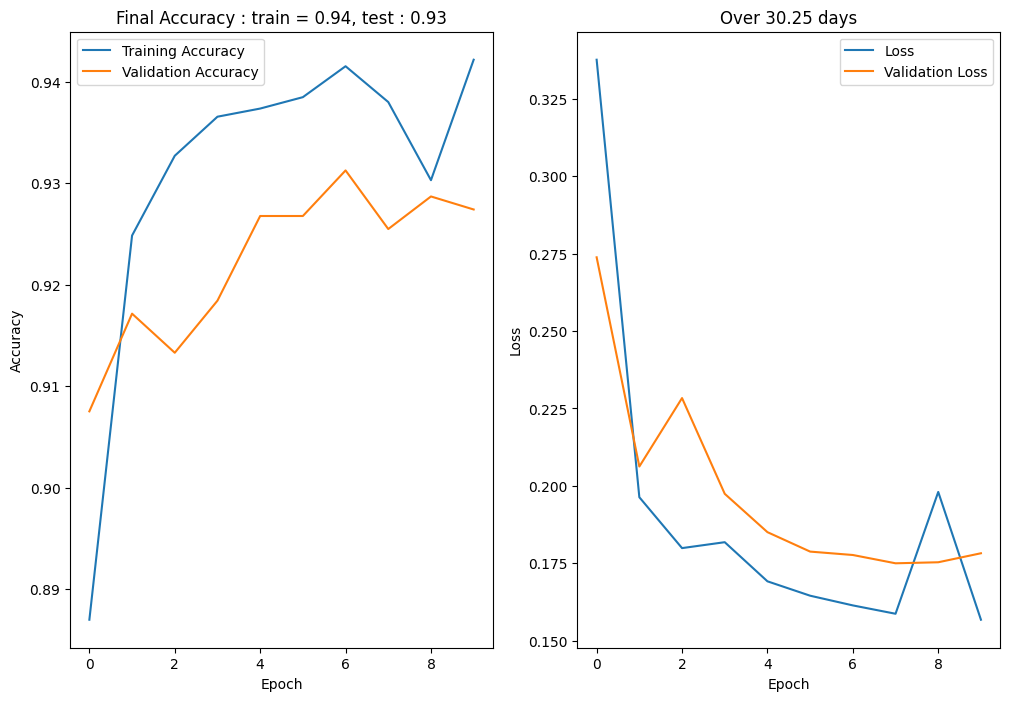

In [19]:
# Plot training and validation loss
fig, ax = plt.subplots(1,2, figsize = (12,8))

if 'bool' not in outcome_to_predict:
    ax[0].plot(history.history['mae'], label='Training MAE')
    ax[0].plot(history.history['val_mae'], label='Validation MAE')
    ax[0].set_title(f"Final MAE : train = {round(history.history['mae'][-1],2)}, test : {round(history.history['val_mae'][-1],2)}")
    ax[0].set_ylabel('MAE')
    
else:
    ax[0].plot(history.history['accuracy'], label='Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title(f"Final Accuracy : train = {round(history.history['accuracy'][-1],2)}, test : {round(history.history['val_accuracy'][-1],2)}")
ax[0].set_xlabel('Epoch')

ax[0].legend()

ax[1].plot(history.history['loss'], label='Loss')
ax[1].plot(history.history['val_loss'], label='Validation Loss')
ax[1].set_title(f"Final Loss : train = {round(history.history['loss'][-1],2)}, test : {round(history.history['val_loss'][-1],2)}")
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()
plt.title(f"Over {n_days} days")
plt.show()

In [20]:
high_mag_files = [file_name for file_name in all_files if float(file_name.split('__')[2].split('.npz')[0]) >= 7.2]

1/1 [==============================] - 0s 46ms/step


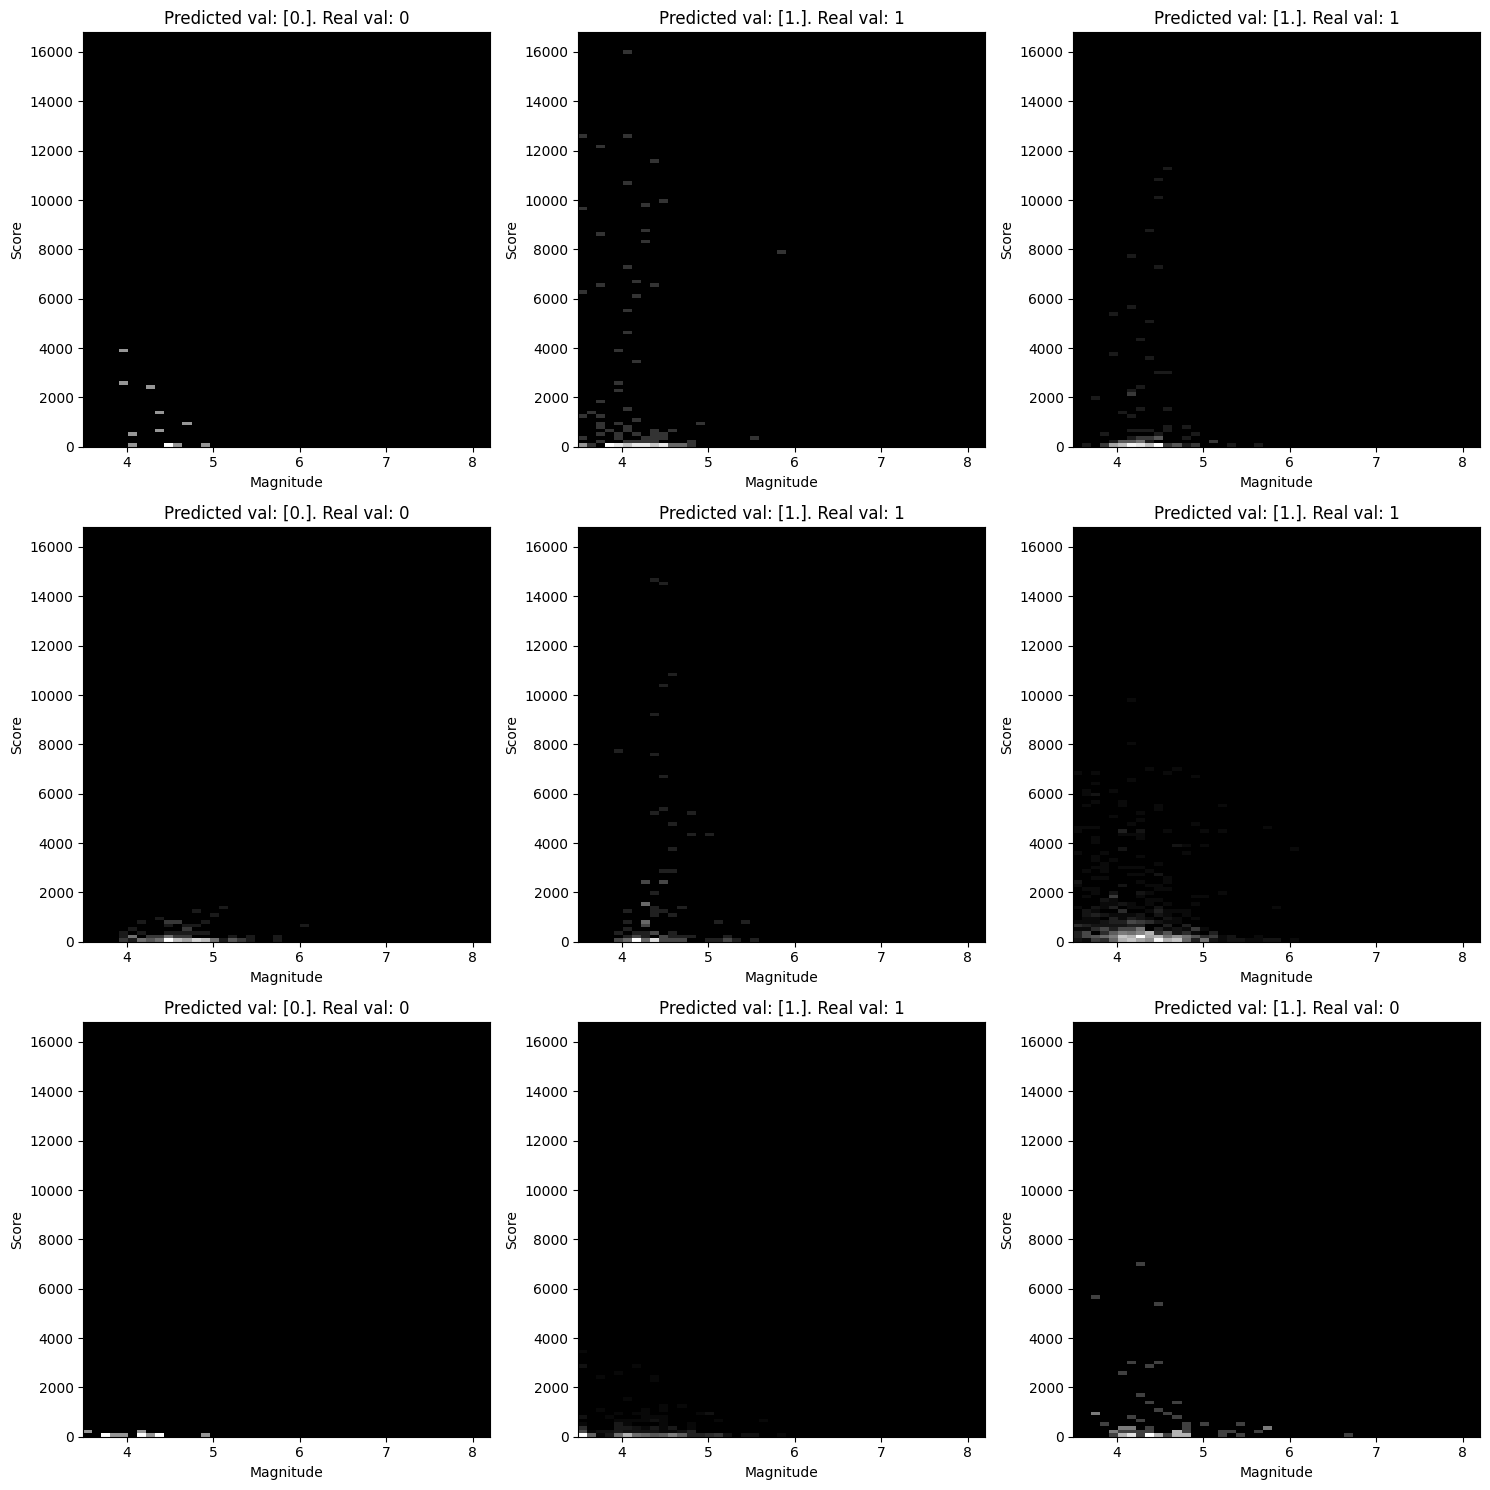

In [21]:
random_files = random.sample(high_mag_files, 9)
random_intensities = []
true_values = []

for file_name in random_files:
    file_path = os.path.join(folder_path, file_name)
    data = np.load(file_path)
    random_intensities.append(data['counts'])

    if outcome_to_predict == 'magnitudes':
        true_values.append(float(file_name.split('__')[2].split('.npz')[0]))
    elif outcome_to_predict == 'aftershocks' or outcome_to_predict == 'aftershocks_bool':
        true_values.append(int(file_name.split('__',2)[1]))
        
if 'bool' in outcome_to_predict:
    true_values = [0 if value == 0 else 1 for value in true_values]

random_intensities = np.array(random_intensities)
random_intensities = random_intensities.reshape(random_intensities.shape + (1,))
predictions = model.predict(random_intensities)

rounded_predictions = np.round(predictions, decimals=1)
if 'bool' in outcome_to_predict:
    rounded_predictions = np.round(rounded_predictions)
if outcome_to_predict == 'aftershocks':
    rounded_predictions = [0 if value <= 0 else np.round(value) for value in rounded_predictions]
    
num_plots = len(random_files)
num_cols = 3
num_rows = num_plots // num_cols

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))

for i, file_name in enumerate(random_files):
    file_path = os.path.join(folder_path, file_name)
    data = np.load(file_path)
    normalized_counts = data['counts']
    mags = data['mags']
    scores = data['scores']


    row = i // num_cols
    col = i % num_cols


    im = axs[row, col].imshow(normalized_counts.T, extent=[mags.min(), mags.max(), scores.min(), scores.max()],
                              origin='lower', aspect='auto', cmap='Greys_r')# , vmax=1.0)
    axs[row, col].set_xlabel('Magnitude')
    axs[row, col].set_ylabel('Score')
    axs[row, col].set_title(f'Predicted val: {rounded_predictions[i]}. Real val: {true_values[i]}')


plt.tight_layout()
plt.show()

In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc


y_pred = model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

cm = confusion_matrix(y_val, y_pred_binary)
tp = cm[0][0] #true positive
fn = cm[0][1] #false negative
fp = cm[1][0] #false positive
tn = cm[1][1] #true negative
print("Confusion Matrix:")
print(cm)
err_prop = (fn + fp)/(tp+fn+fp+tn)
print(f"\nError Proportion : {err_prop*100:.2f}")

49/49 [==============================] - 1s 12ms/step
Confusion Matrix:
[[1313   42]
 [  71  131]]

Error Proportion : 7.26


In [23]:
precision = precision_score(y_val, y_pred_binary)
recall = recall_score(y_val, y_pred_binary)
f1 = f1_score(y_val, y_pred_binary)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Precision: 0.76
Recall: 0.65
F1-Score: 0.70


In [24]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc_score = auc(fpr, tpr)

print(f"AUC Score: {auc_score:.2f}")

AUC Score: 0.95


In [25]:
# df = pd.read_csv(cluster_file_path)
# 
# # There is too much earthquakes in the dataset so I cut it by 1000
# selected_data = df.iloc[::1000]
# 
# latitudes = selected_data['latitude']
# longitudes = selected_data['longitude']
# mags = selected_data['mag']
# 
# latitudes = selected_data['latitude'].tolist()
# longitudes = selected_data['longitude'].tolist()
# scores = selected_data['mag'].tolist()
# 
# fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
# ax.set_global()
# 
# for lat, lon, score in zip(latitudes, longitudes, scores):
#     circle = Circle((lon, lat), radius=score, transform=ccrs.PlateCarree(), edgecolor='black', facecolor='blue', alpha=0.5)
#     ax.add_patch(circle)
# 
# ax.coastlines()
# ax.set_title('World Map with Circles Representing Magnitude (Every 1000th Entry)')

In [28]:
# The goal of this cell is to generate an array of images for the CNN to be trained with

kde_arrays = {}
cluster_counter = 0

# Loop trough clusters
for _, group_df in grouped_dataframe:

    # Checks if main shock has at least 4 aftershocks
    if len(group_df) >= 5:
          
        center_lat = group_df.iloc[0].latitude
        center_lon = group_df.iloc[0].longitude
        nearest_area = group_df.iloc[0].nearest_area 

        cluster_name = f'cluster{cluster_counter}_{nearest_area}'

        weights = group_df.mag**3

        # retrieve longitude and latitude
        data = group_df[['longitude', 'latitude']].values

        kde = gaussian_kde(data.T, weights=weights)

        lon_grid, lat_grid = np.meshgrid(np.linspace(center_lon - 6.5, center_lon + 6.5, 128),
                                          np.linspace(center_lat - 6.5, center_lat + 6.5, 128))
        intensity_grid = kde(np.vstack([lon_grid.ravel(), lat_grid.ravel()]))

        intensity_grid = intensity_grid.reshape(lon_grid.shape)

        kde_arrays[cluster_name] = intensity_grid

        cluster_counter += 1

# create the file for the CNN
np.savez('../ressources/cluster_images.npz', **kde_arrays)


Epoch 1/5
100/100 [==============================] - 9s 87ms/step - loss: 4.5920 - accuracy: 0.0857 - val_loss: 4.0020 - val_accuracy: 0.1287
Epoch 2/5
100/100 [==============================] - 8s 79ms/step - loss: 3.9535 - accuracy: 0.1254 - val_loss: 3.7608 - val_accuracy: 0.1813
Epoch 3/5
100/100 [==============================] - 8s 75ms/step - loss: 3.7310 - accuracy: 0.1501 - val_loss: 3.5898 - val_accuracy: 0.1700
Epoch 4/5
100/100 [==============================] - 8s 77ms/step - loss: 3.5649 - accuracy: 0.1660 - val_loss: 3.5336 - val_accuracy: 0.1775
Epoch 5/5
25/25 [==============================] - 0s 18ms/step - loss: 3.4598 - accuracy: 0.1838
Epoch 1/5
100/100 [==============================] - 8s 78ms/step - loss: 4.7800 - accuracy: 0.0766 - val_loss: 4.1563 - val_accuracy: 0.1225
Epoch 2/5
100/100 [==============================] - 8s 79ms/step - loss: 4.2350 - accuracy: 0.0976 - val_loss: 3.8789 - val_accuracy: 0.1275
Epoch 3/5
100/100 [==============================]

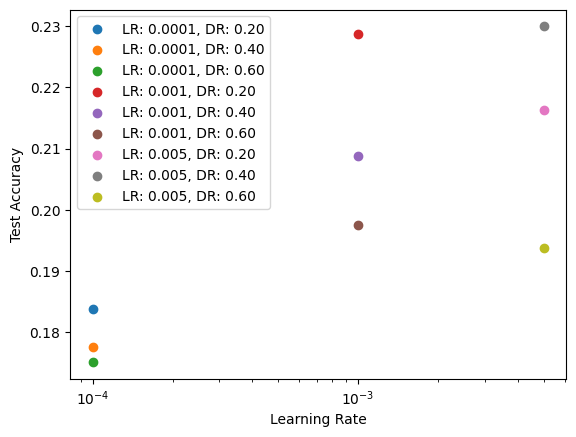

In [29]:

# Load data
data = np.load('../ressources/cluster_images.npz')
images = np.array([data[key] for key in data])

# We need both the image and the nearest area information for the CNN
labels = np.array([key.split('_')[1] for key in data])

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)
one_hot_labels = to_categorical(encoded_labels, num_classes=num_classes)

X_train, X_test, y_train, y_test = train_test_split(images, one_hot_labels, test_size=0.2, random_state=42)

# Function to create and compile a model with specified hyperparameters
def create_model(learning_rate=0.001, dropout_rate=0.5):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

# Hyperparameter tuning
learning_rates = [0.0001, 0.001, 0.005]
dropout_rates = [0.2, 0.4, 0.6]

# Store results
results = []

for lr in learning_rates:
    for dr in dropout_rates:

        # loop trough every combinaison to see which one has the best accuracy
        model = create_model(learning_rate=lr, dropout_rate=dr)
        
        history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
        
        test_loss, test_acc = model.evaluate(X_test, y_test)
        
        results.append({
            'Learning Rate': lr,
            'Dropout Rate': dr,
            'Test Accuracy': test_acc
        })

fig, ax = plt.subplots()

for result in results:
    label = f"LR: {result['Learning Rate']}, DR: {result['Dropout Rate']:.2f}"
    ax.scatter(result['Learning Rate'], result['Test Accuracy'], label=label)

ax.set_xscale('log') 
ax.set_xlabel('Learning Rate')
ax.set_ylabel('Test Accuracy')
ax.legend()
plt.show()

In [30]:
# Function to calculate the percentage difference between predicted and true values
def percentage_difference(true_value, predicted_value):
    if true_value == 0:
        return np.abs(predicted_value) * 100
    else:
        return np.abs((predicted_value - true_value) / true_value) * 100

# function generating a model given the hyperparameters
def build_model_and_evaluate(hidden_layer1_units, hidden_layer2_units, learning_rate):
    model = Sequential()
    model.add(Dense(hidden_layer1_units, activation='relu', input_dim=X_train_scaled.shape[1]))
    model.add(Dense(hidden_layer2_units, activation='relu'))
    model.add(Dense(1, activation='linear'))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    history = model.fit(X_train_scaled, y_train, epochs=5, batch_size=32, validation_split=0.2, verbose=0)
    
    y_pred = model.predict(X_test_scaled)
    
    count_accuracy = 0
    for i in range(len(X_test_scaled)):
        perc_diff = percentage_difference(y_pred.flatten()[i], y_test.iloc[i])
        if perc_diff <= 30:
            count_accuracy += 1

    accuracy = count_accuracy / len(X_test_scaled) * 100
    
    return accuracy, history.history['val_loss'], count_accuracy

data = pd.read_csv(cluster_file_path)

X = data[['mag', 'latitude', 'longitude']]
y = data['depth']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameters to experiment with
hidden_layer1_units_list = [32, 64, 128]
hidden_layer2_units_list = [16, 32, 64]
learning_rate_list = [0.001, 0.01]

# Store accuracy for each combination of hyperparameters
accuracy_results = []

for hidden_layer1_units in hidden_layer1_units_list:
    for hidden_layer2_units in hidden_layer2_units_list:
        for learning_rate in learning_rate_list:

            # Loop trough every combinaisons to see which one has the highest accuracy
            accuracy, _, count_accuracy = build_model_and_evaluate(hidden_layer1_units, hidden_layer2_units, learning_rate)
            accuracy_results.append({
                'hidden_layer1_units': hidden_layer1_units,
                'hidden_layer2_units': hidden_layer2_units,
                'learning_rate': learning_rate,
                'accuracy': accuracy,
                'count_accuracy': count_accuracy
            })

1715/1715 [==============================] - 1s 444us/step


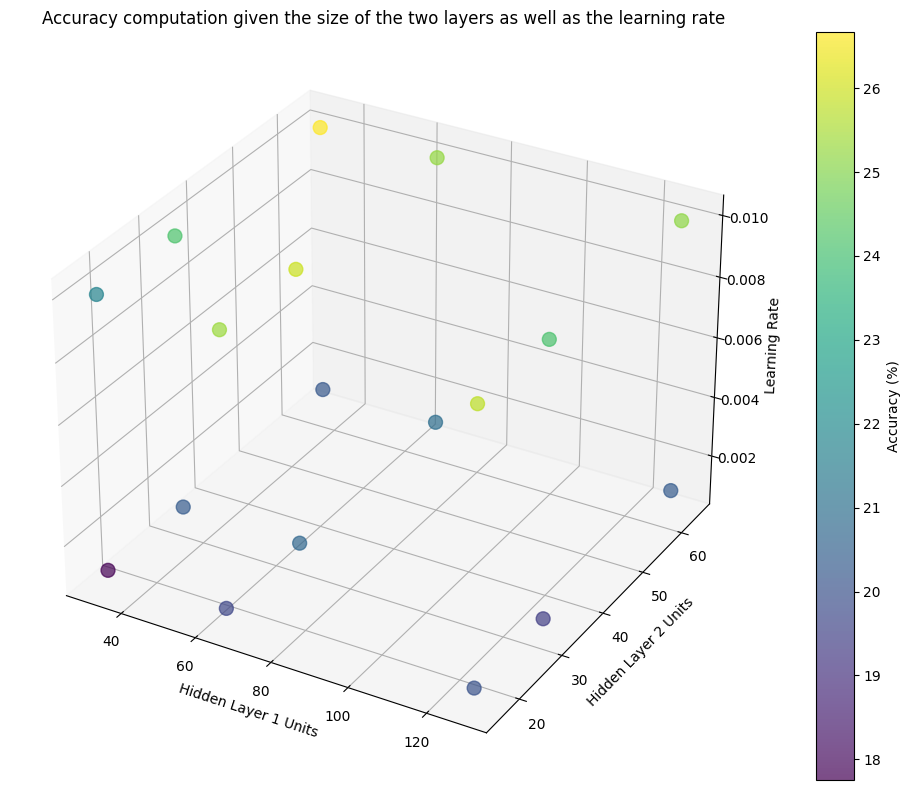

In [ ]:
# Generate a 3D representation of the accuracy given three hyperparameters

fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111, projection='3d')
sc1 = ax1.scatter(
    [result['hidden_layer1_units'] for result in accuracy_results],
    [result['hidden_layer2_units'] for result in accuracy_results],  # Unchanged: hidden layer 2 on z-axis
    [result['learning_rate'] for result in accuracy_results],  # Inverted: learning rate on x-axis
    c=[result['accuracy'] for result in accuracy_results],  # Color based on accuracy
    cmap='viridis',
    s=100,
    alpha=0.7
)
ax1.set_xlabel('Hidden Layer 1 Units')
ax1.set_ylabel('Hidden Layer 2 Units')
ax1.set_zlabel('Learning Rate')
ax1.set_title('Accuracy computation given the size of the two layers as well as the learning rate')
fig.colorbar(sc1, ax=ax1, label='Accuracy (%)')

plt.tight_layout()
plt.show()
